# Question 1

## 1.0 : Installing and importing necessary libraries

we will use hazm and emoji libraries to preprocess the persian texts

In [1]:
!pip install hazm emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 29.3 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=794e2f50b16a385d4368c940dbe9bd5e0905e637d645c6f3910142db1cf6336c
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resol

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import glob
import numpy as np
from matplotlib import pyplot as plt

import re
import hazm
from hazm import Normalizer, word_tokenize, stopwords_list
import emoji

## 1.1 : Loading and visualizing the data





In [2]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d behdadkarimi/persian-tweets-emotional-dataset -p /content/datasets/persian_tweets

%cd /content/datasets/persian_tweets

!unzip persian-tweets-emotional-dataset.zip

cp: cannot stat '/content/drive/MyDrive/kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/behdadkarimi/persian-tweets-emotional-dataset
License(s): copyright-authors
 43% 5.00M/11.6M [00:00<00:00, 47.9MB/s]
100% 11.6M/11.6M [00:00<00:00, 86.0MB/s]
/content/datasets/persian_tweets
Archive:  persian-tweets-emotional-dataset.zip
  inflating: anger.csv               
  inflating: disgust.csv             
  inflating: fear.csv                
  inflating: joy.csv                 
  inflating: sad.csv                 
  inflating: surprise.csv            


pandas library is used to read the csv files and then merge all of them into one dataframe.

In [3]:
folder_path = '/content/datasets/persian_tweets'

files = glob.glob(f'{folder_path}/*.csv')

all_csvs = [pd.read_csv(file) for file in files]

data = pd.concat(all_csvs, ignore_index=True)

print(f'total count of data: {data.shape[0]}')

total count of data: 113829


the count of each emotion label is then visualized by a bar plot

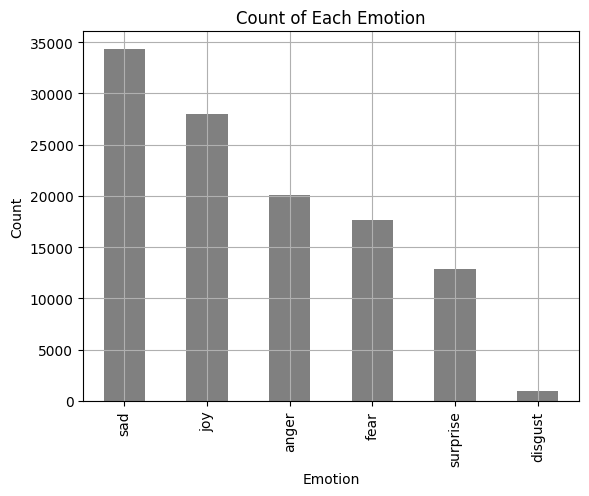

In [4]:
emotion_counts = data['emotion'].value_counts()

emotion_counts.plot(kind='bar', color='grey')

plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Count of Each Emotion')
plt.grid(True)

plt.show()

## 1.2 : Data preprocessing

there are 6 steps taken in the original paper to preprocess and clean the data.


1.   Removing all the HTMLs and URLs
2.   Removing repetitive characters in a word
3.   Removing the stop-words.
4.   Replacing emojis with their equivalent textual representation
5.   Applying stemming
6.   Correcting the incorrect spellings



In [5]:
# Load Persian stopwords
stop_words = set(stopwords_list())

def clean_text(text, url=True, html=True, repetitive=True, stopwords=True, replace_emoji=True):

    # 1. Remove URLs
    if url:
      text = re.sub(r'http\S+|www.\S+', '', text)

    # 1. Remove HTMLs
    if html:
      text = re.sub(r'<.*?>', '', text)

    # 2. Removing repetitive characters
    if repetitive:
      text = re.sub(r'(.)\1+', r'\1', text)

    if stopwords:
      # we use tokenizer to detect stop-words in the text
      words = word_tokenize(text)
      # Detecting stopwords using the persian stop-words sets which we earlier loaded
      # 3. excluding stop words
      words = [word for word in words if word not in stop_words]

      # Join remaining words
      text = ' '.join(words)

    # 4. replacing emojis with their textual equivalent
    if replace_emoji:
      text = emoji.demojize(text, language='alias', delimiters=("", " "))

    return text

# the uncleaned tweets are also saved in case they are needed later
data['uncleaned_tweet'] = data['tweet'].copy()
# applying the function on the 'tweet' column
data['tweet'] = data['tweet'].apply(clean_text)

Showing examples of each of the preprocessing acts

In [6]:
print('URL example:')
example = 'مطالب در سایت www.wikipedia.com موجود است'
cleaned = clean_text(example, url=True, html=False, repetitive=False, stopwords=False, replace_emoji=False)
print(f'original:\n{(example)}\npreprocessed:\n{cleaned}\n')

print('HTML example:')
example = 'یک مثال برای <html>'
cleaned = clean_text(example, url=False, html=True, repetitive=False, stopwords=False, replace_emoji=False)
print(f'original:\n{(example)}\npreprocessed:\n{cleaned}\n')

print('Repetitive characters example:')
example = 'سلام بر شما امروز حال من خیلی خوووووب است'
cleaned = clean_text(example, url=False, html=False, repetitive=True, stopwords=False, replace_emoji=False)
print(f'original:\n{(example)}\npreprocessed:\n{cleaned}\n')

print('Stop words example:')
example = 'سلام بر شما امروز حال من خیلی خوووووب است'
cleaned = clean_text(example, url=False, html=False, repetitive=False, stopwords=True, replace_emoji=False)
print(f'original:\n{(example)}\npreprocessed:\n{cleaned}\n')

print('Emoji example:')
example = 'چه قدر جالب 😂😂😂'
cleaned = clean_text(example, url=False, html=False, repetitive=False, stopwords=False, replace_emoji=True)
print(f'original:\n{(example)}\npreprocessed:\n{cleaned}\n')


URL example:
original:
مطالب در سایت www.wikipedia.com موجود است
preprocessed:
مطالب در سایت  موجود است

HTML example:
original:
یک مثال برای <html>
preprocessed:
یک مثال برای 

Repetitive characters example:
original:
سلام بر شما امروز حال من خیلی خوووووب است
preprocessed:
سلام بر شما امروز حال من خیلی خوب است

Stop words example:
original:
سلام بر شما امروز حال من خیلی خوووووب است
preprocessed:
سلام امروز خوووووب

Emoji example:
original:
چه قدر جالب 😂😂😂
preprocessed:
چه قدر جالب joy joy joy 



## 1.3 : Feature representation

we first need to build ParsBERT Tokenizer and Model. we use the instructions on ParsBERT github page.

In [7]:
# Loading up FarsBert tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

# v3.0
model_name_or_path = "HooshvareLab/bert-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

model = AutoModel.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/426k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


we need to tokenize the texts and also pad them if necessary. max_length=32 is used as instructed in the question description.

In [8]:
def tokenize_and_pad(text):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=32,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoded['input_ids'][0], encoded['attention_mask'][0]

In [9]:
data[['input_ids', 'attention_mask']] = data['tweet'].apply(
    lambda x: pd.Series(tokenize_and_pad(x))
)

## 1.4 : Model Creation and Evaluation

we then will use 'input_ids' column as the features

In [10]:
X = data['input_ids']
y = pd.get_dummies(data['emotion']).values
num_classes = data['emotion'].nunique()

we then split the data into train and test.(0.7 , 0.3)


and then split the train data into train and validation.(0.8 , 0.2)

In [11]:
seed = 101
np.random.seed(seed)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [13]:
print('shapes:')
print(f'X_train:\t{X_train.shape}\ty_train:\t{y_train.shape}')
print(f'X_valid:\t{X_valid.shape}\ty_valid:\t{y_valid.shape}')
print(f'X_test:\t\t{X_test.shape}\ty_test:\t\t{y_test.shape}')

shapes:
X_train:	(63744,)	y_train:	(63744, 6)
X_valid:	(15936,)	y_valid:	(15936, 6)
X_test:		(34149,)	y_test:		(34149, 6)


making shapes ready for tensorflow training

In [14]:
from keras.preprocessing import sequence

max_words = 32
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
X_valid = sequence.pad_sequences(X_valid, maxlen=max_words)

In [15]:
print('shapes:')
print(f'X_train:\t{X_train.shape}\ty_train:\t{y_train.shape}')
print(f'X_valid:\t{X_valid.shape}\ty_valid:\t{y_valid.shape}')
print(f'X_test:\t\t{X_test.shape}\ty_test:\t\t{y_test.shape}')

shapes:
X_train:	(63744, 32)	y_train:	(63744, 6)
X_valid:	(15936, 32)	y_valid:	(15936, 6)
X_test:		(34149, 32)	y_test:		(34149, 6)


Hyper Parameters

In [16]:
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 64
epochs = 3
learning_rate = 0.0001
embed_dim = 120


Model Creation function (CNN_LSTM)

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from keras import backend as K
import numpy as np

In [18]:
def get_model(embed_dim=embed_dim, max_features=50000, optimizer='adam'):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

training function

In [20]:
def model_train(model, epochs=3, batch_size=64, learning_rate=0.001):
    K.set_value(model.optimizer.learning_rate, 0.001)
    model_history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                          epochs=epochs, batch_size=batch_size, verbose=2)
    return model_history

evaluation function

In [21]:
def model_evaluate(model):
    # predict class with test set
    y_pred_test =  np.argmax(model.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))

    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

model initializing and training

*First. learning_rate=0.001, batch_size=64 : COMPARING 'ADAM' and
'SGD'*




In [22]:
learning_rate=0.001
batch_size=64

#### adam

In [ ]:
model_adam = get_model(optimizer='adam')
model_train(model_adam, learning_rate=0.001, batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            11552     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6065358 (23.14 MB)
Trainable params: 6065358 (23.14 MB)
Non-trainable params: 0 (0.00 Byte)
________________

1068/1068 [==============================] - 15s 13ms/step
Accuracy:	86.2%


              precision    recall  f1-score   support

           0       0.89      0.83      0.86      6021
           1       0.97      0.83      0.90       278
           2       0.86      0.89      0.88      5287
           3       0.81      0.90      0.85      8407
           4       0.87      0.85      0.86     10298
           5       0.93      0.84      0.88      3858

    accuracy                           0.86     34149
   macro avg       0.89      0.86      0.87     34149
weighted avg       0.86      0.86      0.86     34149



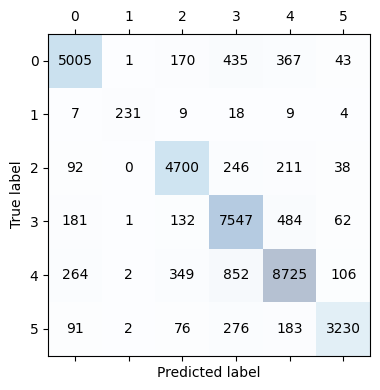

In [ ]:
model_evaluate(model_adam)

#### SGD

In [ ]:
model_sgd = get_model(optimizer='SGD')
model_train(model_sgd, learning_rate=0.001, batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            11552     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6065358 (23.14 MB)
Trainable params: 6065358 (23.14 MB)
Non-trainable params: 0 (0.00 Byte)
________________

1068/1068 [==============================] - 9s 8ms/step
Accuracy:	86.3%


              precision    recall  f1-score   support

           0       0.88      0.84      0.86      6021
           1       0.99      0.83      0.90       278
           2       0.91      0.87      0.89      5287
           3       0.88      0.84      0.86      8407
           4       0.82      0.88      0.85     10298
           5       0.85      0.87      0.86      3858

    accuracy                           0.86     34149
   macro avg       0.89      0.86      0.87     34149
weighted avg       0.86      0.86      0.86     34149



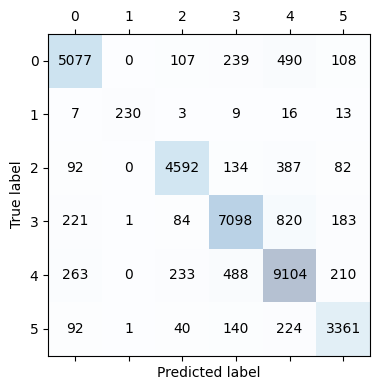

In [ ]:
model_evaluate(model_sgd)

adam wins.

*Second. learning_rate=0.001, OPTIMIZER='ADAM' : COMPARING batch_size=64 vs batch_size=8*




In [23]:
model_8 = get_model(optimizer='adam')
model_train(model_8, learning_rate=0.001, batch_size=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            11552     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6065358 (23.14 MB)
Trainable params: 6065358 (23.14 MB)
Non-trainable params: 0 (0.00 Byte)
________________

1068/1068 [==============================] - 9s 8ms/step
Accuracy:	86.3%


              precision    recall  f1-score   support

           0       0.84      0.86      0.85      6021
           1       0.98      0.85      0.91       278
           2       0.85      0.89      0.87      5287
           3       0.89      0.84      0.87      8407
           4       0.83      0.88      0.86     10298
           5       0.94      0.82      0.88      3858

    accuracy                           0.86     34149
   macro avg       0.89      0.86      0.87     34149
weighted avg       0.87      0.86      0.86     34149



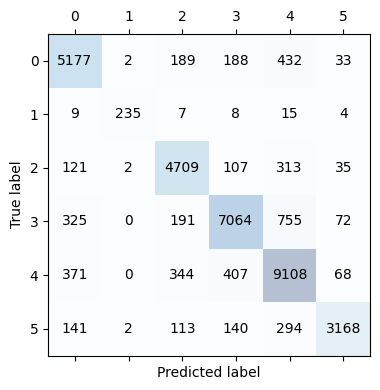

In [24]:
model_evaluate(model_8)

*Third. BATCH_SIZE=64, OPTIMIZER='ADAM' : COMPARING learning_rate = 0.001 vs 0.0001*



In [ ]:
model_adam = get_model(optimizer='adam')
model_train(model_adam, learning_rate=0.0001, batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            11552     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6065358 (23.14 MB)
Trainable params: 6065358 (23.14 MB)
Non-trainable params: 0 (0.00 Byte)
________________

1068/1068 [==============================] - 14s 12ms/step
Accuracy:	86.3%


              precision    recall  f1-score   support

           0       0.90      0.83      0.87      6021
           1       0.98      0.83      0.90       278
           2       0.84      0.89      0.86      5287
           3       0.85      0.87      0.86      8407
           4       0.86      0.86      0.86     10298
           5       0.88      0.87      0.88      3858

    accuracy                           0.86     34149
   macro avg       0.88      0.86      0.87     34149
weighted avg       0.86      0.86      0.86     34149



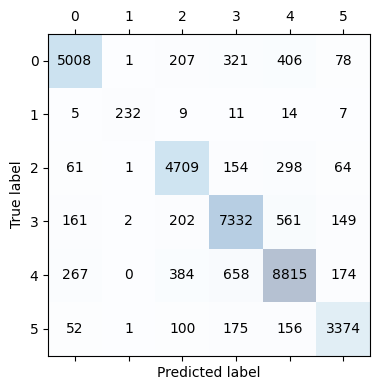

In [ ]:
model_evaluate(model_adam)

*BATCH_SIZE=8, OPTIMIZER='ADAM' : COMPARING learning_rate = 0.001 vs 0.0001*


In [ ]:
model_8 = get_model(optimizer='adam')
model_train(model_8, learning_rate=0.0001, batch_size=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            11552     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6065358 (23.14 MB)
Trainable params: 6065358 (23.14 MB)
Non-trainable params: 0 (0.00 Byte)
________________

1068/1068 [==============================] - 14s 12ms/step
Accuracy:	86.6%


              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6021
           1       1.00      0.83      0.91       278
           2       0.85      0.90      0.87      5287
           3       0.85      0.87      0.86      8407
           4       0.87      0.86      0.87     10298
           5       0.90      0.86      0.88      3858

    accuracy                           0.87     34149
   macro avg       0.89      0.86      0.87     34149
weighted avg       0.87      0.87      0.87     34149



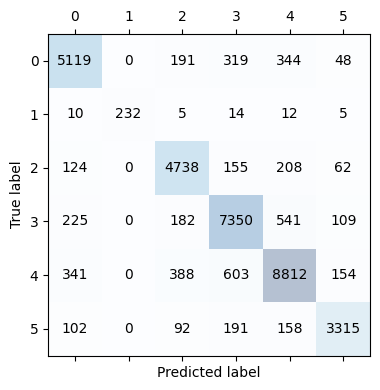

In [ ]:
model_evaluate(model_8)

ONLY CNN

In [ ]:
def get_cnn_model(embed_dim=embed_dim, max_features=50000, optimizer='adam'):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
cnn_model = get_cnn_model(optimizer='adam')
model_train(cnn_model, learning_rate=0.0001, batch_size=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            11552     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 6014630 (22.94 MB)
Trainable params: 6014630 (22.94 MB)
Non-trainable params: 0 (0.00 Byte)
________________

1068/1068 [==============================] - 4s 4ms/step
Accuracy:	85.1%


              precision    recall  f1-score   support

           0       0.87      0.83      0.85      6021
           1       0.94      0.80      0.87       278
           2       0.90      0.84      0.87      5287
           3       0.85      0.84      0.85      8407
           4       0.81      0.88      0.84     10298
           5       0.86      0.85      0.85      3858

    accuracy                           0.85     34149
   macro avg       0.87      0.84      0.85     34149
weighted avg       0.85      0.85      0.85     34149



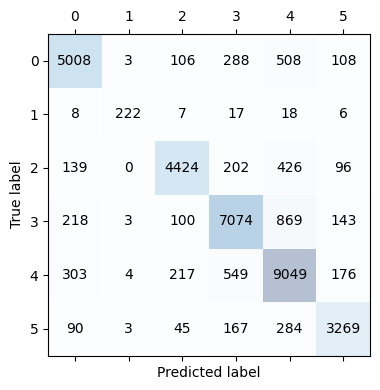

In [ ]:
model_evaluate(cnn_model)

ONLY LSTM

In [ ]:
def get_lstm_model(embed_dim=embed_dim, max_features=50000, optimizer='adam'):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(LSTM(100, dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
lstm_model = get_lstm_model(optimizer='adam')
model_train(lstm_model, learning_rate=0.0001, batch_size=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 lstm (LSTM)                 (None, 100)               88400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6089006 (23.23 MB)
Trainable params: 6089006 (23.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
7968/7968 - 310s - loss: 0.5548 - accuracy: 0.7958 - val_loss: 0.3676 - val_accuracy: 0.8658 - 310s/epoch - 39ms/step
Epoch 2/3
7968/7968 - 292s - loss: 0.3287 - accuracy: 0.8847 - val_loss: 0.3576 - val_accuracy: 0.8741 - 292s/epoch - 37ms/step
Epoch 3/3
7968/7968

1068/1068 [==============================] - 17s 15ms/step
Accuracy:	86.4%


              precision    recall  f1-score   support

           0       0.88      0.82      0.85      6021
           1       0.96      0.85      0.90       278
           2       0.87      0.88      0.87      5287
           3       0.87      0.86      0.86      8407
           4       0.84      0.88      0.86     10298
           5       0.89      0.85      0.87      3858

    accuracy                           0.86     34149
   macro avg       0.88      0.86      0.87     34149
weighted avg       0.86      0.86      0.86     34149



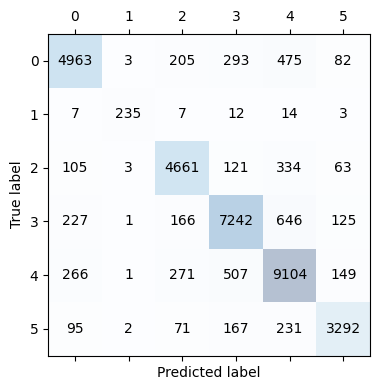

In [ ]:
model_evaluate(lstm_model)

lstm 64 batch

In [ ]:
lstm_model = get_lstm_model(optimizer='adam')
model_train(lstm_model, learning_rate=0.0001, batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 120)           6000000   
                                                                 
 lstm (LSTM)                 (None, 100)               88400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 6089006 (23.23 MB)
Trainable params: 6089006 (23.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
996/996 - 62s - loss: 0.7036 - accuracy: 0.7334 - val_loss: 0.3860 - val_accuracy: 0.8646 - 62s/epoch - 62ms/step
Epoch 2/3
996/996 - 40s - loss: 0.3222 - accuracy: 0.8900 - val_loss: 0.3838 - val_accuracy: 0.8690 - 40s/epoch - 40ms/step
Epoch 3/3
996/996 - 36s - l